This is the LSTM Model

In [37]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helper_functions import preprocess, predictions, is_gpu_working, visualize_ctc

#%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 7.0)
is_gpu_working()

True

In [38]:
window_in = 7
window_out = 1
colsx = ['Cumulative True Cases','Free','Positively Tested','CR', 'Series_No']
colsy = ['Cumulative True Cases','Free','Positively Tested', 'Series_No']
input_shape = (window_in, len(colsx) - 1)
x_train, y_train, x_test, y_test, len_of_ser, num_windows_ser = preprocess(dataframe_csvpath = "data.csv", 
    cols_x = colsx, 
    cols_y = colsy, 
    window_in = window_in, 
    window_out = window_out, 
    data_div_frac = 0.99, 
    popu_size = 80000
)

In [39]:
def LSTM_MODEL():
    model = keras.Sequential(
        [
                               layers.LSTM(64, return_sequences=True, input_shape = input_shape, activation='selu', recurrent_activation='sigmoid', recurrent_dropout=0, unroll=False, use_bias=True),
                               layers.LSTM(128, return_sequences=True, activation='relu', recurrent_activation='sigmoid', recurrent_dropout=0, unroll=False, use_bias=True),
                               layers.LSTM(3, return_sequences=False, activation='linear', recurrent_activation='sigmoid', recurrent_dropout=0, unroll=False, use_bias=True)
        ]
    )
    print(model.summary())
    return model 

In [40]:
model = LSTM_MODEL()
y_train = y_train.reshape((-1, 3*1)) #for our windowsize and model. to be updated
y_test = y_test.reshape((-1, 3*1))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 7, 64)             17664     
_________________________________________________________________
lstm_4 (LSTM)                (None, 7, 128)            98816     
_________________________________________________________________
lstm_5 (LSTM)                (None, 3)                 1584      
Total params: 118,064
Trainable params: 118,064
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
model.compile(
    loss = 'mae',
    optimizer = keras.optimizers.Adam(),
    metrics = ['accuracy']
)

model.fit(
    x_train,
    y_train,
    batch_size = 64,
    epochs = 30,
    verbose = 2
)

model.evaluate(x_test, y_test, batch_size = 32, verbose = 2)

Epoch 1/30
5851/5851 - 489s - loss: 7.7483e-04 - accuracy: 0.8575
Epoch 2/30
5851/5851 - 469s - loss: 3.1464e-04 - accuracy: 0.8977
Epoch 3/30
5851/5851 - 467s - loss: 2.4402e-04 - accuracy: 0.9150
Epoch 4/30
5851/5851 - 467s - loss: 2.1514e-04 - accuracy: 0.9240
Epoch 5/30
5851/5851 - 461s - loss: 2.0156e-04 - accuracy: 0.9283
Epoch 6/30
5851/5851 - 463s - loss: 1.8770e-04 - accuracy: 0.9385
Epoch 7/30
5851/5851 - 471s - loss: 1.7960e-04 - accuracy: 0.9445
Epoch 8/30
5851/5851 - 470s - loss: 1.7840e-04 - accuracy: 0.9560
Epoch 9/30
5851/5851 - 470s - loss: 1.6556e-04 - accuracy: 0.9639
Epoch 10/30
5851/5851 - 474s - loss: 1.6242e-04 - accuracy: 0.9715
Epoch 11/30
5851/5851 - 477s - loss: 1.6052e-04 - accuracy: 0.9770
Epoch 12/30
5851/5851 - 472s - loss: 1.5692e-04 - accuracy: 0.9812
Epoch 13/30
5851/5851 - 474s - loss: 1.5187e-04 - accuracy: 0.9833
Epoch 14/30
5851/5851 - 502s - loss: 1.5110e-04 - accuracy: 0.9836
Epoch 15/30
5851/5851 - 483s - loss: 1.4828e-04 - accuracy: 0.9855
Epoc

[0.00011370383435860276, 1.0]

In [42]:
y_pred, mae = predictions(x_test, y_test, model, len_of_ser, num_windows_ser, window_in = 7, window_out = 1)

tf.Tensor(78.55520839488378, shape=(), dtype=float64)


In [43]:
np.mean(y_pred[0] - y_test[0])

-2.555424872358948e-06

In [69]:
y_pred[:10,0]

array([4.5416418e-05, 4.8876394e-05, 5.1120976e-05, 5.2749216e-05,
       5.4530199e-05, 5.6158722e-05, 5.7937079e-05, 5.9583730e-05,
       5.9913418e-05, 5.9969298e-05], dtype=float32)

In [70]:
y_test[:10, 0]

array([3.750e-05, 6.250e-05, 1.125e-04, 1.625e-04, 2.375e-04, 3.875e-04,
       5.250e-04, 6.250e-04, 8.375e-04, 8.375e-04])

In [75]:
def visualize(y_test, y_pred, x_test, num_plots, num_win_ser, cols_x, col_idx):
    ser_idx = [i for i in range(0, len(y_test), num_win_ser)]
    if num_plots > len(ser_idx):
        return print("Too many plots, reduce the mumber")
    else:
        indx = ser_idx[0:num_plots]
        days = range(num_win_ser)
        for idx in indx:
            CR = x_test[idx][0][3]
            pred = y_pred[idx : idx+num_win_ser, col_idx]
            true = y_test[idx : idx+num_win_ser, col_idx]
            
            plt.title("Y_True V/S Y_Pred, CR: "+ str(CR))
            plt.xlabel('Days')
            plt.ylabel(cols_x[col_idx])
            
            plt.plot(days, pred, label = 'Pred')
            plt.plot(days, true, label = 'True')
            
            plt.legend()
            plt.show()

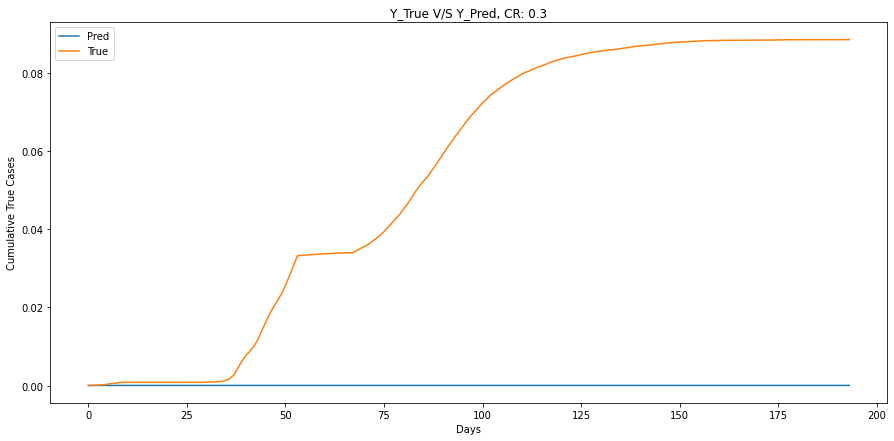

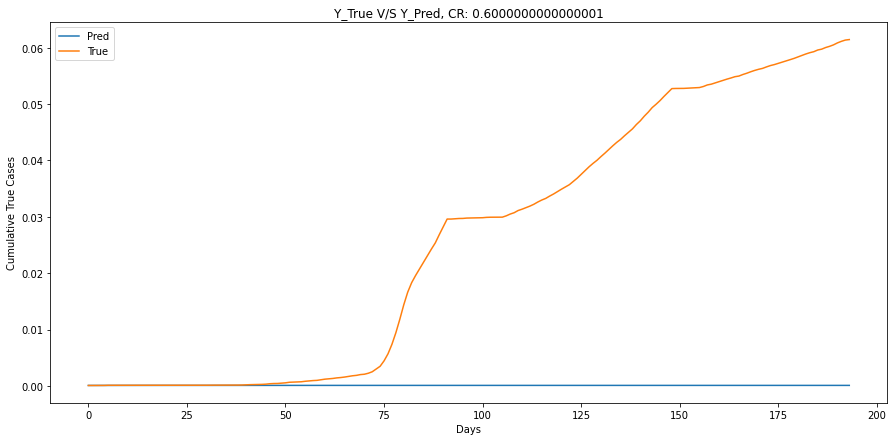

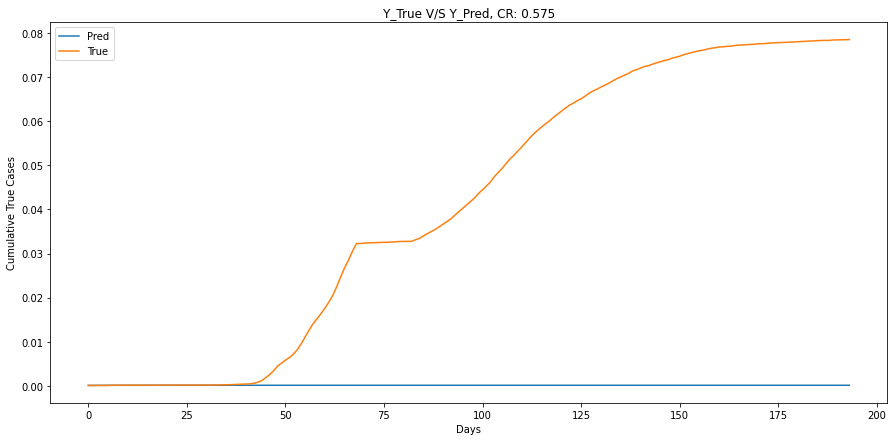

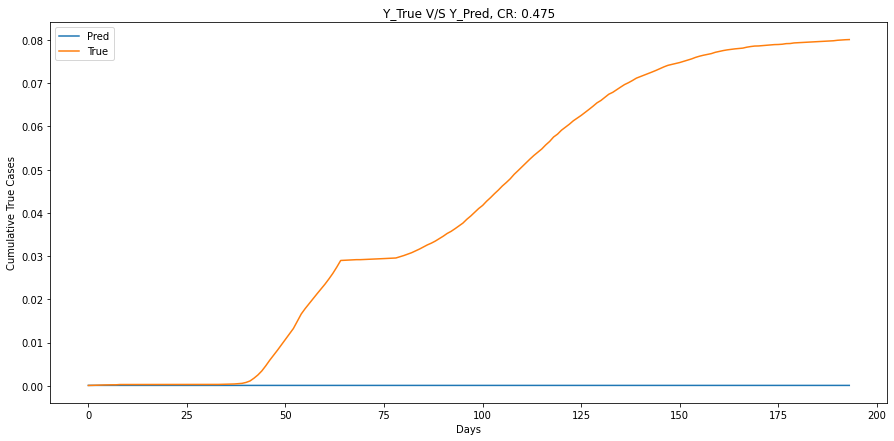

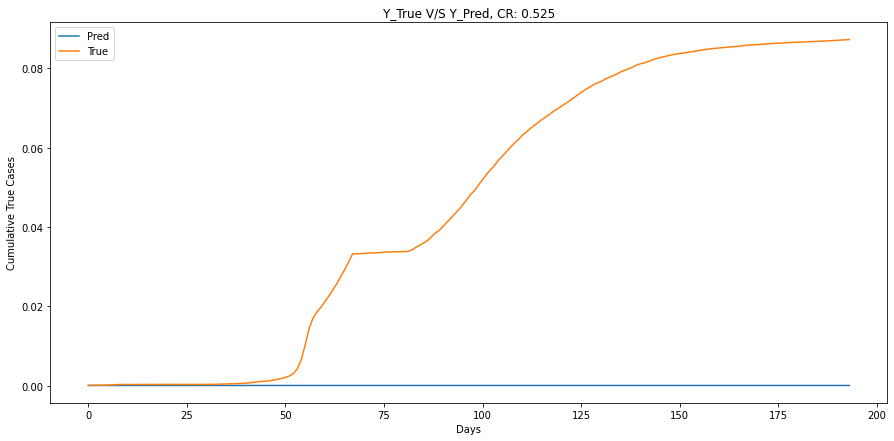

In [76]:
visualize(y_test, y_pred, x_test, num_plots = 5, num_win_ser = num_windows_ser, cols_x = colsx, col_idx = 0)